# Actividad 2

# Controlador en esquema de Espacio de estados.

El objetivo de este trabajo es realizar un controlador pero en este caso partiendo de la base de un esquema de ESPACIO DE ESTADOS.

## Caso 1 - Motor CC

Partiendo de las ecuaciones de motor y parametros calculados en el trabajo practico anterior

$   LAA=7.14e-04 ;
    J=3.1210e-06; 
    Ra=27; 
    B=0; 
    Ki=16.5 
    Km= 0.0606
$


Modelado por las siguientes Ecuaciones diferenciales:

$\frac{di_a}{dt}=\frac{R_A}{L_{AA}}ia-\frac{K_m}{L_{AA}}\omega _r+\frac{1}{L_{AA}}Va $

$ \frac{d\omega_r}{dt}=\frac{K_i}{J}ia-\frac{B_m}{J}\omega _r+\frac{1}{J}T_L $

$ \frac{d\theta _t}{dt}=\omega _r $


Podiamos modelar un controlador PID obteniendo sus constantes como : Ki=0.01 ;  Kp0.5 ; Kd=1


### Espacio de estados

In [23]:
# Importacion de librerias

import numpy as np
import control as ct
import math
import pandas as pd
import matplotlib.pyplot as plt
from control.matlab import *
import cmath as cm
from math import log
import sympy as sp


A partir de las ecuaciones diferenciales modelamos en espacio de estados. Reescribiendo las ecuaciones en matrices y llevando a espacio de estados

In [30]:
# Definir los parámetros del sistema
R_A =27
L_AA =7.14e-4
K_m = 0.0606
J = 3.12e-6
B_m = 0
K_i = 16.5

# Definir las matrices A, B, C y D del sistema de espacio de estados
A = np.array([[-R_A/L_AA, -K_m/L_AA, 0],
              [K_i/J, -B_m/J,0],[0,1,0]])
B = np.array([[1/L_AA,0], [0,-1/J],[0,0]])
C = np.array([[0, 0,1]])
D = np.array([0,0])

print('A:', A)
print('B:', B)
print('C:', C)
print('D:', D)

# Crear el sistema de espacio de estados
#sys= ss(A, B, C, D)
sys = ct.ss(A, B, C, D)
sys

#(A.B
#C.D)


A: [[-3.78151261e+04 -8.48739496e+01  0.00000000e+00]
 [ 5.28846154e+06  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]]
B: [[   1400.56022409       0.        ]
 [      0.         -320512.82051282]
 [      0.               0.        ]]
C: [[0 0 1]]
D: [0 0]


StateSpace(array([[-3.78151261e+04, -8.48739496e+01,  0.00000000e+00],
       [ 5.28846154e+06,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00]]), array([[   1400.56022409,       0.        ],
       [      0.        , -320512.82051282],
       [      0.        ,       0.        ]]), array([[0., 0., 1.]]), array([[0., 0.]]))

In [33]:
# Definir el tiempo de simulación y tiempo de integración
#Tiempo de integracion de euler -> obtener polos lazo abierto

poles= np.linalg.eigvals(A)
print('Polos:', poles)

#El polo mayor es 0 pero no es parte de la dinamica de el sistema(indica no estabilidad)
dominant_complex_pole = poles[1]  # Se elige uno de los polos complejos conjugados

#Tiempo intrgracion de euler
tR = np.log(0.95) / np.abs(dominant_complex_pole.real)
print('Tiempo de integración de Euler:', tR)

#Tiempo de simulacion


Polos: [     0.           +0.j         -18907.56302521+9558.06875985j
 -18907.56302521-9558.06875985j]
Tiempo de integración de Euler: -2.71284534760823e-06
Tiempo de simulación: -0.0002435623342811479


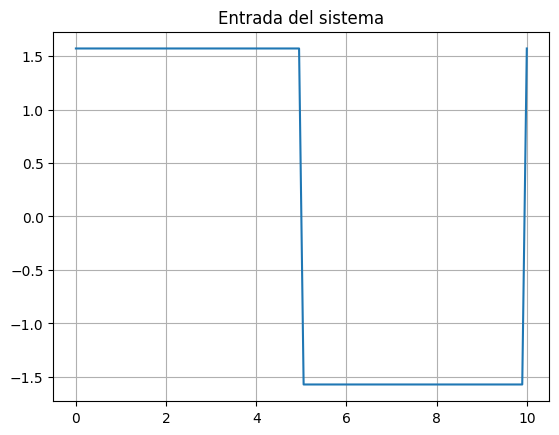

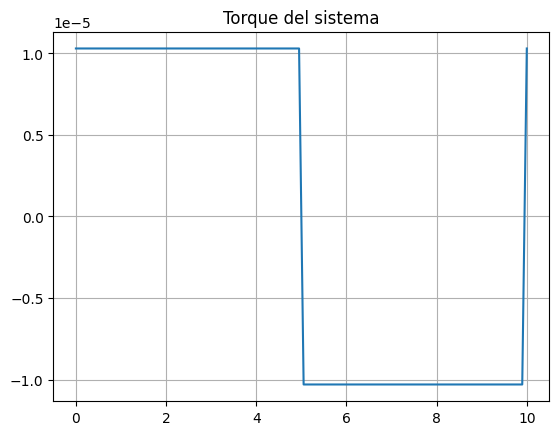

In [44]:
#Entrada sistema y torque
# Función de entrada sistema
def input_function(t):
    if t % 10 < 5:
        return np.pi / 2
    else:
        return -np.pi / 2

# Define the time vector
t = np.linspace(0, 10, 100)

# Define the input function
def input_function(t):
    if t % 10 < 5:
        return np.pi / 2
    else:
        return -np.pi / 2

# Generate the input values
u = [input_function(ti) for ti in t]

plt.plot(t, u)
plt.title('Entrada del sistema')
plt.grid()
plt.show()

#Funcion torque valor tl=1.03e-05
def torque_function(t):
    if t % 10 < 5:
        return 1.03e-5
    else:
        return -1.03e-5
    
#Graficando
t = np.linspace(0, 10, 100)
torque = [torque_function(ti) for ti in t]
plt.plot(t, torque)
plt.title('Torque del sistema')
plt.grid()


In [43]:
#Corroborar que el sistema sea controlable
# Matriz de controlabilidad
M_cont=[B, A@B ,A@A@B]
print('Matriz de controlabilidad:', M_cont)
range_M_cont = np.linalg.matrix_rank(M_cont)
print('Rango de la matriz de controlabilidad:', range_M_cont)

Matriz de controlabilidad: [array([[   1400.56022409,       0.        ],
       [      0.        , -320512.82051282],
       [      0.        ,       0.        ]]), array([[-5.29623614e+07,  2.72031890e+07],
       [ 7.40680888e+09,  0.00000000e+00],
       [ 0.00000000e+00, -3.20512821e+05]]), array([[ 1.37413325e+12, -1.02869202e+12],
       [-2.80089411e+14,  1.43863019e+14],
       [ 7.40680888e+09,  0.00000000e+00]])]
Rango de la matriz de controlabilidad: [2 2 2]


In [ ]:
#Simulacion del sistema para el angulo y para la corriente 
#Partiendo de condiciones iniciales nulas


